<a href="https://colab.research.google.com/github/aalr007/MAAM/blob/main/A3b_DL_TC5033_AD2023_text_classifier_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> ***Métodos Avanzados de Aprendizaje Máquina*** </center>
## <center> ***Equipo 38*** </center>
## <center> ***Activity 3b*** </center>
### Profesor: Dr José Antonio Cantoral Cevallos
### Alumnos:
* Luis Alfredo Negron Naldos A01793865
* Javier Muñoz Barrios A01794423
* Aurelio Antonio Lozano Rábago A01081266

#### <p style='text-align: right;'> Noviembre del 2023 </p>

## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [ ]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
tf.config.list_physical_devices('GPU')

import torch.nn.init as init

In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [ ]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [ ]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [ ]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [ ]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [ ]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [ ]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [ ]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


Data loaders, se crean dataloaders para procesar los datos por lotes.

In [ ]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [ ]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [ ]:
EMBEDDING_SIZE = 50 # complete
NEURONS = 200 # complete
LAYERS = 2 # complete
NUM_CLASSES = 4 # complete

In [ ]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super(RNN_Model_1, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size)




        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden, num_layers=layers, batch_first=True)



        self.fc = nn.Linear(hidden, num_classes)


    def forward(self, x):
        embedded = self.embedding_layer(x)

        # Apply dropout before RNN


        output, hidden = self.rnn(embedded)

        output = output[:, -1, :]



        scores = self.fc(output)
        return scores


In [ ]:

def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    cost = 0.
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device=device, dtype = torch.long)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi)
            _, pred = scores.max(dim=1)
            num_correct += (pred == yi).sum()
            num_total += pred.size(0)

        return float(num_correct)/num_total

In [ ]:
def train(model, optimiser, epochs=100):
    model = model.to(device=device) #The model is passed to the device.
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):   #loader form from tensors
            model.train()                             #train the model
            xi = xi.to(device=device, dtype=torch.int64)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
        acc = accuracy(model, val_loader)
        print(f'Epoch:{epoch}, costo: {cost.item()}, accuracy: {acc},')
    pass

In [ ]:
epochs = 15 # define
lr=0.0001
# instantiate model
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)


In [ ]:
train(rnn_model, optimiser=optimiser,  epochs=epochs)

Epoch:0, costo: 1.304917573928833, accuracy: 0.3873333333333333,
Epoch:1, costo: 1.0881885290145874, accuracy: 0.5350833333333334,
Epoch:2, costo: 0.8485769033432007, accuracy: 0.6058333333333333,
Epoch:3, costo: 0.7743237614631653, accuracy: 0.6513333333333333,
Epoch:4, costo: 0.8090227842330933, accuracy: 0.70175,
Epoch:5, costo: 0.699571430683136, accuracy: 0.7175,
Epoch:6, costo: 0.6328996419906616, accuracy: 0.7445833333333334,
Epoch:7, costo: 0.511635959148407, accuracy: 0.7620833333333333,
Epoch:8, costo: 0.6061598062515259, accuracy: 0.7775833333333333,
Epoch:9, costo: 0.4723663330078125, accuracy: 0.7925,
Epoch:10, costo: 0.4999869763851166, accuracy: 0.8029166666666666,
Epoch:11, costo: 0.4842722713947296, accuracy: 0.81425,
Epoch:12, costo: 0.3947145640850067, accuracy: 0.8205833333333333,
Epoch:13, costo: 0.4505183696746826, accuracy: 0.8224166666666667,
Epoch:14, costo: 0.411288321018219, accuracy: 0.8300833333333333,


In [ ]:
print(f'{accuracy(rnn_model, test_loader):.4f}')

0.8291


In [ ]:
def sample_text(model, loader):
    model = model.to(device=device)
    model.eval()  # Asegúrate de que el modelo esté en modo de evaluación
    predictions = []  # Almacenar las predicciones

    with torch.no_grad():
        for xi, _ in loader:
            xi = xi.to(device=device, dtype=torch.int32)  # Asegúrate de que los datos sean del tipo adecuado
            scores = model(xi)
            _, pred = scores.max(dim=1)
            predictions.extend(pred.cpu().numpy())  # Agregar las predicciones a la lista

    return predictions

In [ ]:
sample_text(rnn_model, test_loader)

[1,
 1,
 2,
 0,
 2,
 3,
 1,
 0,
 2,
 2,
 0,
 1,
 1,
 3,
 3,
 2,
 3,
 1,
 0,
 3,
 1,
 2,
 2,
 2,
 0,
 3,
 1,
 0,
 2,
 2,
 3,
 3,
 0,
 1,
 2,
 1,
 0,
 1,
 1,
 2,
 0,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 3,
 0,
 3,
 3,
 0,
 0,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 3,
 2,
 3,
 0,
 2,
 0,
 3,
 3,
 1,
 3,
 0,
 3,
 3,
 0,
 1,
 0,
 1,
 2,
 0,
 1,
 3,
 1,
 0,
 0,
 3,
 1,
 2,
 2,
 3,
 0,
 2,
 2,
 3,
 3,
 2,
 1,
 1,
 2,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 3,
 0,
 3,
 1,
 3,
 0,
 3,
 3,
 0,
 3,
 2,
 2,
 3,
 2,
 1,
 3,
 0,
 0,
 0,
 3,
 1,
 2,
 0,
 1,
 0,
 0,
 1,
 3,
 0,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 3,
 0,
 2,
 2,
 3,
 2,
 1,
 3,
 2,
 3,
 0,
 1,
 1,
 0,
 2,
 2,
 0,
 0,
 2,
 3,
 2,
 0,
 3,
 3,
 2,
 3,
 1,
 2,
 1,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 1,
 0,
 0,
 2,
 1,
 3,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 2,
 1,
 3,
 1,
 2,
 2,
 2,
 0,
 2,
 3,
 2,
 3,
 0,
 2,
 3,
 3,
 2,
 0,
 1,
 3,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 3,
 1,
 2,
 0,
 0,


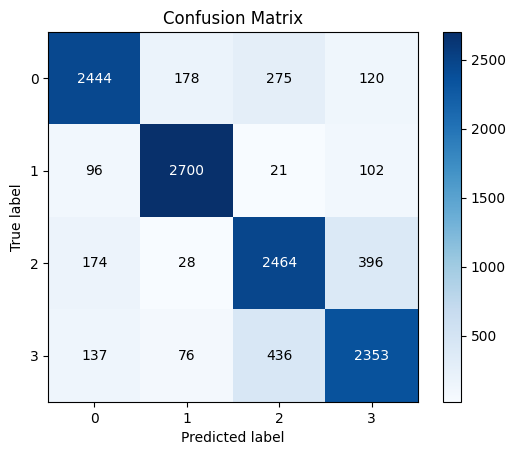

In [ ]:
# create confusion matrix
# Initialize empty lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation data and make predictions
with torch.no_grad():
    for xi, yi in val_loader:
        xi = xi.to(device=device, dtype=torch.int32)
        scores = rnn_model(xi)
        _, pred = scores.max(dim=1)

        true_labels.extend(yi.cpu().numpy())  # Store the true labels
        predicted_labels.extend(pred.cpu().numpy())  # Store the predicted labels

# Create the confusion matrix
skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels, normalize=False)

# Show the confusion matrix
plt.show()
